# MNIST GPU Deep Learning Benchmark with H2O Deep Water
In reference to [Szilard's Benchmark-DL](https://github.com/szilard/benchm-dl)

In [28]:
import sys, os
import os.path
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
PATH = os.path.expanduser("~/h2o-3/")
#h2o.shutdown(False)
h2o.init(nthreads=4) ## to mimic p2.xlarge
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 mins 09 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,33 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.62 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


### Hardware check

In [21]:
!nvidia-smi

Mon Oct 24 13:43:37 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.44                 Driver Version: 367.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0      On |                  N/A |
| 34%   47C    P8    11W / 180W |   1471MiB /  8097MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:81:00.0      On |                  N/A |
| 29%   42C    P8    11W / 180W |   2503MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Data preparation

In [22]:
train = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")
predictors  = list(range(0,784))
resp        = 784

train[predictors] = train[predictors]/255.0
train[resp] = train[resp].asfactor()
nclasses    = train[resp].nlevels()[0]

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Define the model architecture

In [23]:
def cnn(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')

    conv1 = mx.symbol.Convolution(data=data, kernel=(4,4), num_filter=32)
    relu1 = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1 = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2 = mx.symbol.Convolution(data=pool1, kernel=(3,3), num_filter=16)
    relu2 = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2 = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
    drop = mx.symbol.Dropout(data=pool2, p=0.2)

    flatten = mx.symbol.Flatten(data=drop)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=128)
    relu3 = mx.symbol.Activation(data=fc1, act_type="relu")

    fc2 = mx.symbol.FullyConnected(data=relu3, num_hidden=64)
    relu4 = mx.symbol.Activation(data=fc2, act_type="relu")

    fc3 = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    net = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return net
cnn(nclasses).save("/tmp/cnn.json")

### Train the model

In [24]:
model = H2ODeepWaterEstimator(epochs=10,
                              learning_rate=0.05,
                              learning_rate_annealing=1e-5,
                              momentum_start=0.9,
                              momentum_stable=0.9,
                              mini_batch_size=128,
                              train_samples_per_iteration=0,
                              standardize=False,
                              ignore_const_cols=False,
                              network_definition_file="/tmp/cnn.json",
                              image_shape=[28,28],
                              channels=1,
                              device_id=[0])

model.train(x=predictors,y=resp, training_frame=train)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


### It takes about 25 seconds to train for 10 epochs (600,000 samples)

In [25]:
model.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477341810757_1
Status of Deep Learning Model: user, 261.3 KB, predicting C785, 10-class classification, 600,320 training samples, mini-batch size 128



,input_neurons,rate,momentum
,784,0.0071396,0.9




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00341608755362
RMSE: 0.0584473057858
LogLoss: 0.0130219159831
Mean Per-Class Error: 0.00429358594087
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
1007.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0029703,"3 / 1,010"
0.0,1100.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0018149,"2 / 1,102"
0.0,1.0,997.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0020020,2 / 999
0.0,0.0,1.0,1030.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0048309,"5 / 1,035"
0.0,0.0,0.0,0.0,998.0,0.0,1.0,1.0,0.0,2.0,0.0039920,"4 / 1,002"
0.0,0.0,0.0,3.0,0.0,933.0,0.0,0.0,2.0,0.0,0.0053305,5 / 938
1.0,0.0,1.0,0.0,0.0,0.0,1001.0,0.0,2.0,0.0,0.0039801,"4 / 1,005"
0.0,1.0,2.0,0.0,0.0,0.0,0.0,1013.0,0.0,3.0,0.0058881,"6 / 1,019"
0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,969.0,2.0,0.0041110,4 / 973
2.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,990.0,0.0080160,8 / 998


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9957346
2,0.9998016
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-24 13:43:49,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-24 13:44:04,19.376 sec,4284 obs/sec,1.0005333,1,60032.0,0.1277121,0.0589206,0.0192441
,2016-10-24 13:44:22,36.262 sec,15639 obs/sec,8.0042667,8,480256.0,0.0646082,0.0149983,0.0051582
,2016-10-24 13:44:27,41.179 sec,16942 obs/sec,10.0053333,10,600320.0,0.0584473,0.0130219,0.0042654


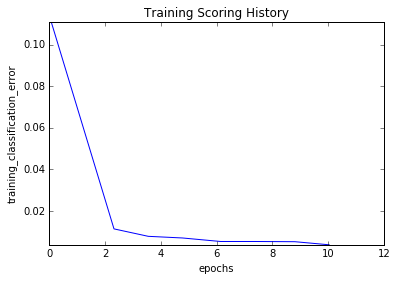

In [9]:
model.plot()

### Let's evaluate the test set performance

In [10]:
test = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")
test[predictors] = test[predictors]/255.0
test[resp] = test[resp].asfactor()

print(model.model_performance(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsMultinomial: deepwater
** Reported on test data. **

MSE: 0.00676826671789
RMSE: 0.0822694762223
LogLoss: 0.0240304507942
Mean Per-Class Error: 0.00826879421027
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
973.0,0.0,0.0,0.0,1.0,0.0,5.0,1.0,0.0,0.0,0.0071429,7 / 980
0.0,1132.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0026432,"3 / 1,135"
1.0,0.0,1024.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0077519,"8 / 1,032"
0.0,0.0,1.0,1000.0,0.0,2.0,0.0,4.0,3.0,0.0,0.0099010,"10 / 1,010"
0.0,0.0,0.0,0.0,976.0,0.0,0.0,1.0,1.0,4.0,0.0061100,6 / 982
1.0,0.0,0.0,5.0,0.0,884.0,1.0,1.0,0.0,0.0,0.0089686,8 / 892
0.0,2.0,0.0,0.0,1.0,3.0,952.0,0.0,0.0,0.0,0.0062630,6 / 958
0.0,2.0,2.0,0.0,0.0,0.0,0.0,1022.0,1.0,1.0,0.0058366,"6 / 1,028"
1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,965.0,4.0,0.0092402,9 / 974
1.0,2.0,0.0,1.0,6.0,3.0,0.0,5.0,1.0,990.0,0.0188305,"19 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9918
2,0.9989
3,0.9998000
4,0.9999999
5,0.9999999
6,0.9999999
7,0.9999999
8,0.9999999
9,0.9999999
10,0.9999999


In [27]:
h2o.download_all_logs("/tmp/")

Writing H2O logs to /tmp/h2ologs_20161024_014520.zip


u'/tmp/h2ologs_20161024_014520.zip'